In [1]:
# General imports, will clean up as required
import numpy as np
import csv as csv
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
import warnings
from math import sqrt
from collections import Counter
style.use('fivethirtyeight')
import random
import pandas as pd
import re
from sklearn import preprocessing, cross_validation
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
import seaborn as sb
import xgboost as xgb

def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print (x)
    pd.reset_option('display.max_rows')

/home/mint/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/mint/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# Import train & test datasets, will manipulate both sets together but will not look at test data
# This assumes there will not be missing values in the test columns where there are none in the train columns

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [6]:
# New column for sex as 1 & 0
df_train['Gender'] = df_train['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
df_test['Gender'] = df_test['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

In [7]:
print (df_train["Embarked"].mode())
print (df_test["Embarked"].mode())

0    S
dtype: object
0    S
dtype: object


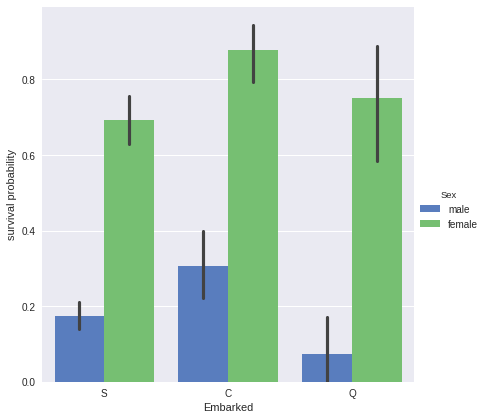

In [8]:
# Fill missing Embarked with most common departure location
df_train["Embarked"] = df_train["Embarked"].fillna('S')
df_test["Embarked"] = df_test["Embarked"].fillna('S')

g = sb.factorplot(x="Embarked", y="Survived", hue="Sex", data= df_train,size=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("survival probability")

In [9]:
# New column map as a number
df_train['Nembarked'] = df_train['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
df_test['Nembarked'] = df_test['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

In [10]:
# Attacking Cabin, Will keep simple as my guess is more people who's cabin we don't know probably did not survive
# will not try and fill the missing cabins accuratly as there is not a clear correlation between cabin level & price
#Take first letter of the cabin which represents the level
df_train['CabinL'] = df_train['Cabin'].str[:1]
df_test['CabinL'] = df_test['Cabin'].str[:1]
# Fill missing values with 'Z'
df_train["CabinL"] = df_train["CabinL"].fillna("Z")
df_test["CabinL"] = df_test["CabinL"].fillna("Z")

In [11]:
# Convert to numbers
df_train['CabinN'] = df_train['CabinL'].map( {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'T': 7, 'Z': 7}).astype(int)
df_test['CabinN'] = df_test['CabinL'].map( {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'T': 7, 'Z': 7}).astype(int)

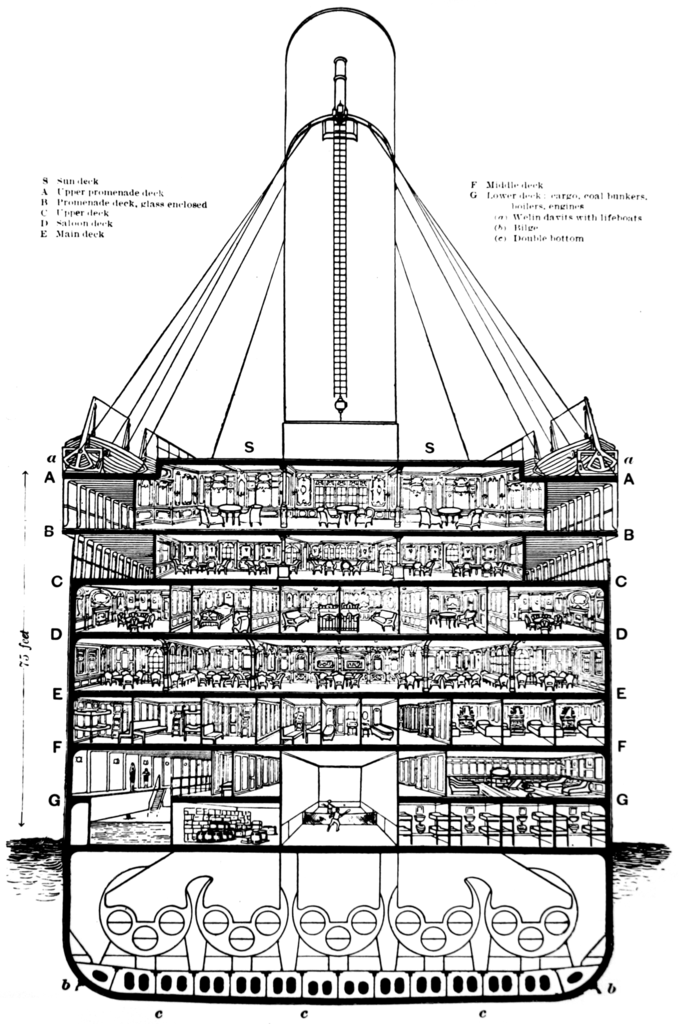

In [12]:
from IPython.display import Image
Image("Titanic_cutaway_diagram.png",height=700,width=500)

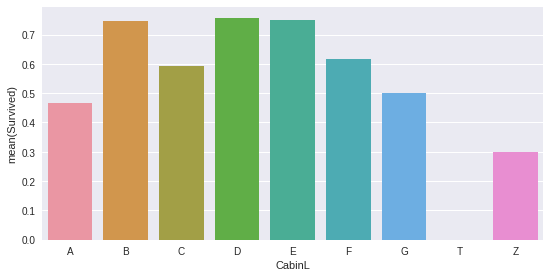

In [13]:
# Z is the letter given to unknown cabin numbers
# average survived passengers by Cabin
axis1 = plt.subplots(1,1,figsize=(8,4))
average_Cabin = df_train[["CabinL", "Survived"]].groupby(['CabinL'],as_index=False).mean()
sb.barplot(x='CabinL', y='Survived', data=average_Cabin)

In [14]:
# for i in df_train['Name']:
#     match = re.search('([A-Za-z]+)\.', i)
#     if match:                      
#         print match.group()
#     else:
#         print 'did not find'
# ABOVE me trying to figure out to search for title
df_train['Title'] = df_train['Name'].map(lambda x : (re.search('([A-Za-z]+)\.', x)).group())
df_test['Title'] = df_test['Name'].map(lambda x : (re.search('([A-Za-z]+)\.', x)).group())

In [15]:
df_train.groupby('Title').count()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender,Nembarked,CabinL,CabinN
Title,,,,,,,,,,,,,,,,
Capt.,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Col.,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2
Countess.,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Don.,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1
Dr.,7,7,7,7,7,6,7,7,7,7,3,7,7,7,7,7
Jonkheer.,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1
Lady.,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Major.,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
Master.,40,40,40,40,40,36,40,40,40,40,7,40,40,40,40,40


In [16]:
# Convert titles to numbers grouping weird titles as rare and the multiples of Miss. & Mrs. together respectivley
df_train['Title'] = df_train['Title'].map({'Capt.': 0, 'Col.': 0, 'Countess.': 0, 'Don.': 0, 'Dr.': 0, 'Jonkheer.': 0, 'Lady.': 0, 'Major.': 0, 'Master.': 1, 'Miss.': 2, 'Mlle.': 2, 'Mme.': 3, 'Mr.': 4, 'Mrs.': 3, 'Ms.': 2, 'Rev.': 0, 'Sir.': 0, 'Dona.': 2})
# Had to look at test as there was one title not included in the training Dona.
df_test['Title'] = df_test['Title'].map({'Capt.': 0, 'Col.': 0, 'Countess.': 0, 'Don.': 0, 'Dr.': 0, 'Jonkheer.': 0, 'Lady.': 0, 'Major.': 0, 'Master.': 1, 'Miss.': 2, 'Mlle.': 2, 'Mme.': 3, 'Mr.': 4, 'Mrs.': 3, 'Ms.': 2, 'Rev.': 0, 'Sir.': 0, 'Dona.': 2})

In [17]:
# Fill age with a much better solution from Mohit
df_train["Age"] = df_train.groupby(['Sex','Pclass','Title'])['Age'].transform(lambda x: x.fillna(x.median()))
df_test["Age"] = df_test.groupby(['Sex','Pclass','Title'])['Age'].transform(lambda x: x.fillna(x.median()))

In [18]:
# Number of family members
df_train['Family'] = df_train['SibSp'] + df_train['Parch']
df_test['Family'] = df_test['SibSp'] + df_test['Parch']

In [19]:
# Missing fare in test data
mean_fare = df_test['Fare'].mean()
df_test['Fare'].fillna(mean_fare, inplace=True)

In [20]:
 # encoding into 3 categories:
pclass_dummies = pd.get_dummies(df_train['Pclass'],prefix="Pclass")
    
# adding dummy variables
df_train = pd.concat([df_train,pclass_dummies],axis=1)
    
# removing "Pclass"
    
df_train.drop('Pclass',axis=1,inplace=True)


 # encoding into 3 categories:
pclass_dummies = pd.get_dummies(df_test['Pclass'],prefix="Pclass")
    
# adding dummy variables
df_test = pd.concat([df_test,pclass_dummies],axis=1)
    
# removing "Pclass"
    
df_test.drop('Pclass',axis=1,inplace=True)

In [21]:
embarked_dummies = pd.get_dummies(df_train['Embarked'],prefix='Embarked')
df_train = pd.concat([df_train,embarked_dummies],axis=1)
df_train.drop('Embarked',axis=1,inplace=True)

embarked_dummies = pd.get_dummies(df_test['Embarked'],prefix='Embarked')
df_test = pd.concat([df_test,embarked_dummies],axis=1)
df_test.drop('Embarked',axis=1,inplace=True)

In [22]:
# encoding in dummy variable
titles_dummies = pd.get_dummies(df_train['Title'],prefix='Title')
df_train = pd.concat([df_train,titles_dummies],axis=1)
    
# removing the title variable
df_train.drop('Title',axis=1,inplace=True)

# encoding in dummy variable
titles_dummies = pd.get_dummies(df_test['Title'],prefix='Title')
df_test = pd.concat([df_test,titles_dummies],axis=1)
    
# removing the title variable
df_test.drop('Title',axis=1,inplace=True)

In [23]:
# dummy encoding ...
cabin_dummies = pd.get_dummies(df_train['CabinN'],prefix='CabinN')
    
df_train = pd.concat([df_train,cabin_dummies],axis=1)

df_train.drop('CabinL',axis=1,inplace=True)
df_train.drop('CabinN',axis=1,inplace=True)

# dummy encoding ...
cabin_dummies = pd.get_dummies(df_test['CabinN'],prefix='CabinN')
    
df_test = pd.concat([df_test,cabin_dummies],axis=1)

df_test.drop('CabinL',axis=1,inplace=True)
df_test.drop('CabinN',axis=1,inplace=True)
    

In [24]:
# introducing other features based on the family size
df_train['Singleton'] = df_train['Family'].map(lambda s : 1 if s == 1 else 0)
df_train['SmallFamily'] = df_train['Family'].map(lambda s : 1 if 2<=s<=4 else 0)
df_train['LargeFamily'] = df_train['Family'].map(lambda s : 1 if 5<=s else 0)

# introducing other features based on the family size
df_test['Singleton'] = df_test['Family'].map(lambda s : 1 if s == 1 else 0)
df_test['SmallFamily'] = df_test['Family'].map(lambda s : 1 if 2<=s<=4 else 0)
df_test['LargeFamily'] = df_test['Family'].map(lambda s : 1 if 5<=s else 0)

In [33]:
# Now to test on the real test dataset
# Save Passenger Ids from Test before removing
ids = df_test['PassengerId'].values

In [34]:
df_trainR = df_train.drop(['Name', 'Ticket', 'Sex', 'Cabin'], 1)
df_testR = df_test.drop(['Name', 'Ticket', 'Sex', 'Cabin'], 1)

In [35]:
X_train = np.array(df_trainR.drop(['Survived'], 1))
y_train = np.array(df_trainR['Survived'])
test = np.array(df_testR)
# Make X_train & y_train dataframe for ease of use below

X_traindf = df_trainR.drop(['Survived'], 1)
y_traindf = df_trainR['Survived']

In [36]:
# Preprocessing Not Working
M_train = preprocessing.scale(X_train)
M_test = preprocessing.scale(test)

In [48]:
clf = xgb.XGBClassifier().fit(M_train, y_train)

In [49]:
features = pd.DataFrame()
features['feature'] = X_traindf.columns
features['importance'] = clf.feature_importances_

In [50]:
features.sort(['importance'],ascending=False)

/home/mint/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,feature,importance
4,Fare,0.228426
1,Age,0.221658
0,PassengerId,0.175973
7,Family,0.071066
18,Title_4,0.042301
10,Pclass_3,0.040609
6,Nembarked,0.032149
26,CabinN_7,0.027073
14,Title_0,0.023689
5,Gender,0.023689


In [51]:
model = SelectFromModel(clf, prefit=True)
train_new = model.transform(M_train)
train_new.shape

(891, 6)

In [52]:
test_new = model.transform(M_test)
test_new.shape

(418, 6)

In [67]:
from sklearn.grid_search import GridSearchCV
cv_params = {'max_depth': [3,4,5,6,7,8], 'min_child_weight': [3,5,7,9], 'n_estimators': [50,80,100,140,200], 'learning_rate': [0.1,0.01]}
ind_params = {'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'accuracy', cv = 10, n_jobs = -1) 
# Optimize for accuracy since that is the metric used in the Adult Data Set notation



In [68]:
optimized_GBM.fit(train_new, y_train)

print('Best score: {}'.format(optimized_GBM.best_score_))
print ('Best parameters: {}'.format(optimized_GBM.best_params_))

Best score: 0.8282828282828283
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 50}


In [69]:
output = optimized_GBM.predict(test_new).astype(int)
df_output = pd.DataFrame()
df_output['PassengerId'] = ids
df_output['Survived'] = output
df_output[['PassengerId','Survived']].to_csv('XGBoost_w_Hyperparameters.csv',index=False)